# Subreddit Predictions

In this notebook we will create a model which can predict which subreddit a post belongs to, based solely on the post title.

The first step is to gather a large amount of data and to store it in a pandas dataframe.

In [1]:
import pandas as pd
import praw
import secrets

In [2]:
user_agent = "Subreddit-Predictor 0.1 by /u/IsThisATrollBot"

reddit = praw.Reddit(
    client_id=secrets.client_ID,
    client_secret=secrets.client_secret,
    password=secrets.password,
    user_agent=user_agent,
    username=secrets.username,
)

Because pushshift is down, we are limited to the amount of data we can gather at a time. So we will choose posts from the 10 most popular subreddits.

In [96]:
# Get the 10 most popular subreddits
top_subreddits = ['announcements', 'funny', 'AskReddit', 'gaming', 'Awww', 'Music', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

Use Praw to instantiate 'reddit'

In [97]:
# Create an empty list to store the posts
posts = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in top_subreddits:
    subreddit_posts = reddit.subreddit(sub).new(limit=1000)
    for post in subreddit_posts:
        posts.append(post)
posts

[Submission(id='t93ec3'),
 Submission(id='pg006s'),
 Submission(id='pbmy5y'),
 Submission(id='nw2hs6'),
 Submission(id='mi01fg'),
 Submission(id='mcisdf'),
 Submission(id='ipitt0'),
 Submission(id='hrrh23'),
 Submission(id='hi3oht'),
 Submission(id='gxas21'),
 Submission(id='g0s6tn'),
 Submission(id='fub7xo'),
 Submission(id='ft3e3q'),
 Submission(id='fo7p5b'),
 Submission(id='fdi1rw'),
 Submission(id='f8y9nx'),
 Submission(id='e75f07'),
 Submission(id='dpqd0z'),
 Submission(id='dpa8rn'),
 Submission(id='dbf9nj'),
 Submission(id='d6li3o'),
 Submission(id='ct2gcb'),
 Submission(id='chdx1h'),
 Submission(id='cevm31'),
 Submission(id='bpfyx1'),
 Submission(id='blev4z'),
 Submission(id='b8574q'),
 Submission(id='aqzfl6'),
 Submission(id='aq9h0k'),
 Submission(id='9uobsx'),
 Submission(id='9ld746'),
 Submission(id='9jf8nh'),
 Submission(id='9ipbun'),
 Submission(id='9epjue'),
 Submission(id='9bvkqa'),
 Submission(id='93qnm5'),
 Submission(id='8we31l'),
 Submission(id='8sth30'),
 Submission(

In [7]:
posts[0].id

't93ec3'

Collect some data

In [98]:
# Create a list of dictionaries containing the data for each post
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name } for post in posts]

# Create a Pandas dataframe from the list of dictionaries
df = pd.DataFrame(data)
df

,id,title,subreddit
0,t93ec3,This subreddit is closed for new posts and com...,announcements
1,pg006s,COVID denialism and policy clarifications,announcements
2,pbmy5y,"Debate, dissent, and protest on Reddit",announcements
3,nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
4,mi01fg,Second,announcements
...,...,...,...
9309,znoi4x,AITA - Upstairs Renter Constantly Turns Heat U...,AmItheAsshole
9310,znogl7,AITA for sneaking my tablet since I’m 21 and d...,AmItheAsshole
9311,znoeo8,"AITA for taking my little brother out for ""too...",AmItheAsshole
9312,znodur,AITA for wanting to go out with my coworkers a...,AmItheAsshole


### Clean the data

In [34]:
# Remove all non-alpha-numeric characters
df['title'] = df['title'].str.replace(r'[^a-zA-Z0-9 ]', '', regex = True)

# Make all the text lowercase
df['title'] = df['title'].str.lower()

# Remove empty rows
df['title'] = df['title'].str.strip()
filter = df['title'] == ''
df = df.drop(df[filter].index)

df


,id,title,subreddit
0,t93ec3,this subreddit is closed for new posts and com...,announcements
1,pg006s,covid denialism and policy clarifications,announcements
2,pbmy5y,debate dissent and protest on reddit,announcements
3,nw2hs6,sunsetting secret santa and reddit gifts,announcements
4,mi01fg,second,announcements
...,...,...,...
8327,zl1n1e,the kings of class trailer comedic mockumenta...,videos
8328,zl1m4u,spiderman across the spiderverse trailer 2 2023,videos
8329,zl0p8f,this kids show is nuts,videos
8330,zl0fj0,tribal people try texas bbq for the first time,videos


### Split the data into test and training data

In [99]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(df['title'], df['subreddit'], test_size=0.2)

# Get the indices of the test set samples for later use
test_indices = X_test.index

## Aproach 1: Naive Bag-of-Words and Support Vector Machine

In [100]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(X_train)

from sklearn.svm import SVC
# Create an SVM model and fit it to the vectors and subreddit labels
model = SVC()
model.fit(vectors, Y_train)

SVC()

In [101]:
# Test the model on some new data
new_titles = ['This is a sample title', 'Another sample title']
test_vectors = vectorizer.transform(new_titles)
predictions = model.predict(test_vectors)

output = pd.DataFrame({'title': new_titles, 'Prediction':predictions})
output


,title,Prediction
0,This is a sample title,funny
1,Another sample title,Awww


In [102]:
# Test the model on some new data
test_vectors = vectorizer.transform(X_test)
predictions = model.predict(test_vectors)

output = pd.DataFrame({'title': X_test, 'Prediction':predictions, 'Actual':Y_test})
output['Correct'] = output['Prediction'] == output['Actual']
output


,title,Prediction,Actual,Correct
6408,The shapes of regolith particles on airless bo...,science,science,True
37,Extra! Extra! We're launching a News tab as a ...,worldnews,announcements,False
9005,WIBTA the asshole for moving away from my disa...,AmItheAsshole,AmItheAsshole,True
6623,Acetohydroxyacid Synthase (AHAS) Inhibitor‐Bas...,worldnews,science,False
6610,Cold exposure induces dynamic changes in circu...,science,science,True
...,...,...,...,...
141,We've revamped reddit's mobile site! Let us k...,AskReddit,announcements,False
760,“The investment guide the Antichrist doesn’t w...,funny,funny,True
6440,New CRISPR-based tool inserts large DNA sequen...,science,science,True
343,Argentine at this moment...,pics,funny,False


### Visualize the results

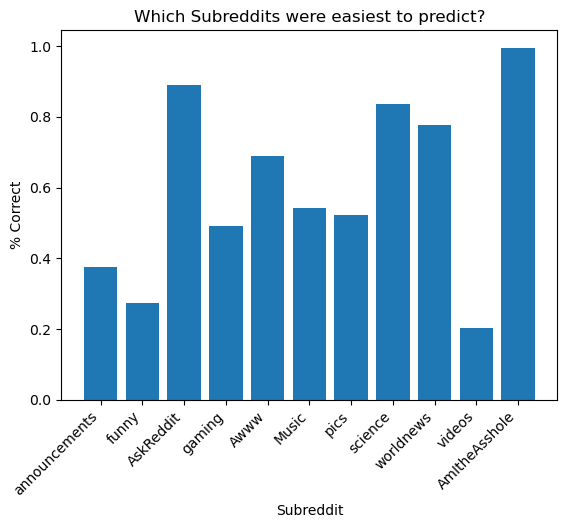

In [136]:
import matplotlib.pyplot as plt

dic = {}
for sub in top_subreddits:
    total = len(output[output['Actual'] == sub])
    correct = len(output[(output['Actual'] == sub) & (output['Correct'] == True)])
    if total != 0:
        dic[sub] = correct/total
    else:
        print(sub)

# Extract the keys and values from the dictionary
keys = list(dic.keys())
values = list(dic.values())

# Create the bar graph
plt.bar(keys, values)

# Adjust the x-axis tick locations and labels
plt.xticks(rotation=45, ha='right')

# Add a title and axis labels
plt.title('Which Subreddits were easiest to predict?')
plt.xlabel('Subreddit')
plt.ylabel('% Correct')

# Show the plot
plt.show()

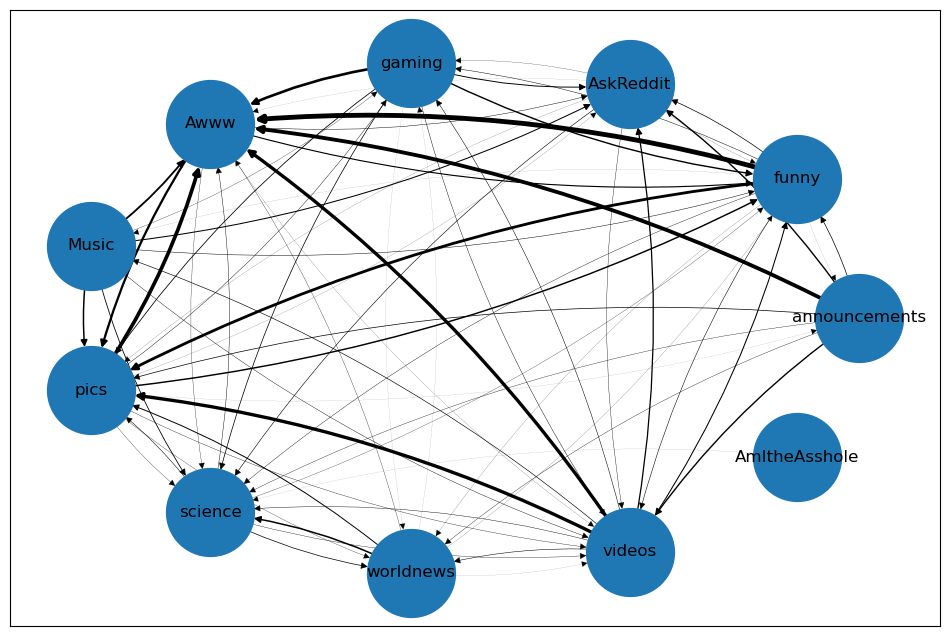

In [194]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

scale = 10

# Add the nodes to the graph
for sub in top_subreddits:
    G.add_node(sub)

# Add the edges to the graph, along with their weights
misguesses = {}
for source in top_subreddits:
    total = len(output[output['Actual'] == source])
    for target in top_subreddits:
        if source != target:
            misguessed = len(output[(output['Actual'] == source) & (output['Prediction'] == target)])
            misguesses[(source,target)] = misguessed/total
            if misguessed > .01:
                G.add_edge(source, target, weight = scale * misguessed/total)

# Draw the graph
pos = nx.circular_layout(G)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# Create a figure that is 8 inches wide and 6 inches tall
plt.figure(figsize=(12, 8))

edge_width = [d['weight'] for (u,v,d) in G.edges(data=True)]
#nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='black', arrows=True, arrowsize=20)

nx.draw_networkx(G, pos,   width = edge_width, connectionstyle="arc3,rad=0.1", node_size = 4000)
#nx.draw(G, pos=pos)
plt.show()